# Classifier Validation

### Visualizing Classifier Output
For logistic regression classifier we estimate probabilities that a given event belongs to a class of recalled events. The probability formula is given by:

$P(x)=\left({1+e^{-\left(B+\sum w_i x_i\right)}}\right)^{-1}$

which implies that we are looking for a dividing hyperplane that will separate recalled and non-recalled events. Every point along this hyperplane is assigned the same confidence score by the classifier as described earlier. This score is specifically the classification threshold. The equation of this hyperplane is simply

$B+\sum w_i x_i = 0$

where $B$ is the intercept and $w_i$'s are weights coefficients fitted by Logistic Regression algorithm. $x_i$'s are features of the classifier - in our case $x_i$'s denote mean powers for the i-th combination of spectral frequency and bipolar pair. While ROC and AUC can give you a sense of classifier performance, sometimes it is nice to be able to visualize how well the dividing hyperplane separates data points belonging to the two classes (here recalled vs non recalled) We can do it by projecting N dimensional space into two dimennsions and plot dividing plane as well as individual , color-coded events. Let's rewrite $B+\sum w_i x_i = 0$ as 

$ B+X+Y = 0 $ where $X = \sum_{i=0}^{i=200} w_i x_i$ and $Y = \sum_{i=201}^{i=N} w_i x_i$. The number 200 is arbitrary here. The idea is that we can treat a weighted sum of first n features as one variable and the weighted sum of the remaining features as another variable and plot those on a scatter plot. Here $n=200$, and $N$ denotes total number of features. Since $ B+X+Y = 0 $ is the exponent in the logistic probability function, the line along which the probability of the data point belonging to either class is exactly 0.5 (the threshold) is called the dividing line. The equation of the dividing line is exactly 

$ B+X+Y = 0 $ 

because when the exponent is $0$,

$P(x)=\left({1+e^{-0}}\right)^{-1}=0.5$

Now, the data points that lie above the dividing line will get assigned high probability (here, of being recalled) and those that lie below will get assigned low probability

In [1]:
import numpy as np
import pandas as pd
import cmlreaders as cml
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold
from scipy.stats import ttest_ind

Text(0.5, 1.0, 'Distribution of classifier weights')

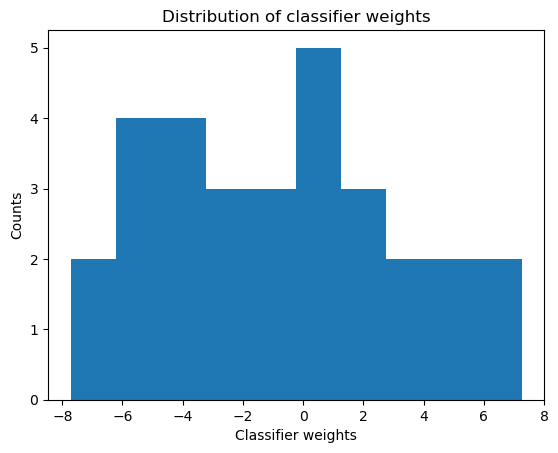

In [2]:
# load data of observations of health indicators with outcomes of
# whether or not a tumor is malignant.
X, y = load_breast_cancer(return_X_y=True)

# z-score features to make them comparable and visualize
X = (X - X.mean(axis=0)) / X.std(axis=0, ddof=1)

lr_classifier = LogisticRegression(C=100, penalty='l2', class_weight='balanced',
                                   solver='liblinear')
lr_classifier.fit(X, y)

# Inspect the classifier weights.
w_tmp = np.squeeze(lr_classifier.coef_)
plt.hist(w_tmp)
plt.xlabel('Classifier weights')
plt.ylabel('Counts')
plt.title('Distribution of classifier weights')

In [3]:
# For demonstration purposes, take the weighted sum of the first chunk
# of features as X values and last chunk of features for Y values.
# A quick-and-direct dimensionality reduction of the feature space.

# Create an empty weight object with column for intercept and columns
# for classifier-derived weights.
w = np.zeros(len(w_tmp)+1)
w[0] = lr_classifier.intercept_
w[1:] = w_tmp

# Use dot product to get weighted sum of first 200 features as X
# and remaining features as Y.
x_project = np.dot(X[:,:15], w[1:16])
y_project = np.dot(X[:,15:], w[16:])
ind = y==0

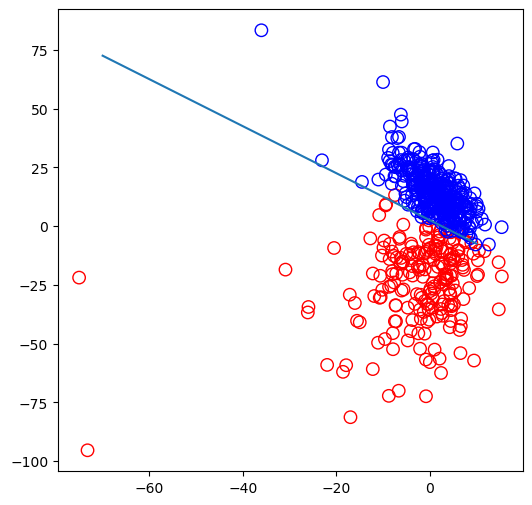

In [4]:
# Plot results.
fig = plt.figure(figsize=(6, 6))

x = np.linspace(-70,10, 100)
plt.plot(x, -w[0]-x)
plt.scatter(x_project[ind], y_project[ind], s=80, facecolors='none', edgecolors='r')
plt.scatter(x_project[~ind], y_project[~ind], s=80, facecolors='none', edgecolors='b')

## Cross-validation
In the previous assignment, we learned how to train a classifier on observed features and labels\. But we trained the classifier and tested its performance on the same dataset, which is very problematic for evaluating the classifier's performance. Why?

Imagine some students went to a review session before an exam, but the teaching assistant leading the review simply gave away all the test questions during the review session. Predictably the students would ace the exam, but would this indicate anything about whether they deeply understood the covered material? Of course not! Even students who understood the material poorly could still memorize a set of arbitrary solutions and regurgitate them.

Similarly, if the purpose of machine learning methods is to make predictions on new data -- e.g. will this subject remember this word? -- then we want to test its performance on new data, i.e., data it hasn't been trained on! Training a model involves finding a very particular set of weights on each feature, and those weights can end up being very specifically tuned to the training data. A classifier will do a great job predicting labels on data it already saw, but it will fail to predict labels for new and somewhat different data.

<center>
<img src="https://cdn-images-1.medium.com/max/800/1*tBErXYVvTw2jSUYK7thU2A.png" width=500>
</center>

In ML parlance, we want our models to avoid **overfitting** the training data and to **generalize** to held-out datasets. Ensuring this generalizability by testing on held-out data is called **validation**. Let's see how it's done!

<center>
<img src="https://cdn-images-1.medium.com/max/800/1*4G__SV580CxFj78o9yUXuQ.png" width=650>
</center>
    
<a href="https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6">Image source</a>


In [5]:
# Select our training data events to be a random 80% of the data.
# Remember that the feature matrix is events X features in shape

idx = np.repeat(np.arange(5), len(X)//5 + 1)
idx = np.tile(np.arange(5), len(X)//5 + 1)[:len(X)]
idx = np.random.permutation(idx)
train_mask = idx != 4
X_train = X[train_mask, :]
y_train = y[train_mask]

# Make our testing data from the last session.
X_test = X[~train_mask, :]
y_test = y[~train_mask]

print('Train:'+str(X_train.shape))
print('Test:'+str(X_test.shape))

Train:(456, 30)
Test:(113, 30)


In [6]:
# Instantiate the classifier and fit to training data.
C_ = 100
lr_classifier = LogisticRegression(C=C_, penalty='l2', class_weight='balanced', solver='liblinear')
lr_classifier.fit(X_train, y_train)

LogisticRegression(C=100, class_weight='balanced', solver='liblinear')

In [7]:
# Test the model on the held-out data
prob_array = lr_classifier.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, prob_array)
print(auc)

1.0


**Exercise: Let's again assess the robustness of logistic classification on the breast cancer data example dataset, and add positive and negative balanced random noise from amplitude +/-0 through +/- 30, but this time we will separate out each set of our X values into a separate "testing" set of data (use the first 480 observations), and a "training" set of data (the rest of the observations), and make the plot again with noise amplitude on the x axis, and the AUC obtained on the y axis.**

Now let's try all possible combinations of leave-one-fold-out train/test splits, and compute the average AUC across all splits.

In [8]:
test_aucs = []
test_rocs = []

# Loop through all possible sessions as the testing set.
for test_idx in np.unique(idx):
    mask = idx == test_idx
    # Make our train/test splits across sessions.
    X_train = X[mask]
    y_train = y[mask]
    
    X_test = X[~mask]
    y_test = y[~mask]
    
    # Fit the classfier to the training set.
    lr_classifier = LogisticRegression(C=C_, penalty='l2', class_weight='balanced', solver='liblinear')
    lr_classifier.fit(X_train, y_train)
    
    # Compute the AUC for each testing set.
    prob_array = lr_classifier.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, prob_array)
    test_aucs.append(auc)
    
    # Compute the ROC for each testing set.
    roc_curve_data = roc_curve(y_test, prob_array)
    test_rocs.append(roc_curve_data)

In [9]:
print(test_aucs)
print(np.mean(test_aucs))

[0.9790416683907808, 0.9788156902187579, 0.9936429308565532, 0.9897007223942208, 0.9932282663955262]
0.9868858556511677


While these are all quite good AUCs, indiciating the classifier can distinguish benign from malignant tumors well above chance, none of them are quite as high as our training-set AUC from before. That's to be expected -- essentially, the classifier overfit to the training data.

Text(0, 0.5, 'TPR')

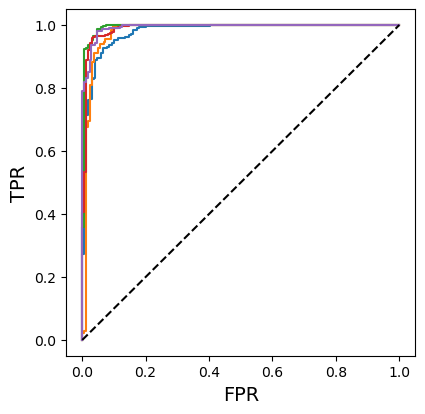

In [10]:
# Plot the ROC curve for each held-out session.
plt.figure(figsize=(4.5, 4.5))

for roc_ in test_rocs:
    fpr = roc_[0]
    tpr = roc_[1]
    
    plt.plot(fpr, tpr)

# Make the plot pretty.
plt.plot((0.0,1.0),(0.,1.),'k--')
plt.xlabel('FPR', fontsize=14)
plt.ylabel('TPR', fontsize=14)

In [11]:
# Note that k-fold cross validation can be implemented directly in sklearn.
# we imported at the top of the notebook
kf = KFold(n_splits=5)

data = np.arange(5) + 5
print('Data to split:', data)
print('Splits:')
for train_index, test_index in kf.split(data):
    print(train_index)
    print(test_index)
    print()

Data to split: [5 6 7 8 9]
Splits:
[1 2 3 4]
[0]

[0 2 3 4]
[1]

[0 1 3 4]
[2]

[0 1 2 4]
[3]

[0 1 2 3]
[4]



## Feature Selection

### Using insight, cleverness, and expertise
It is critical for broad success to not treat machine learning methods as black-box magic.  They are strongly subject to garbage-in-garbage-out behaviors, where if you feed them data with no direct predictive relationship to the phenomenon in question, you will not get meaningful or generalizable results.

This opens up a wide space where reasoning should be inserted for choosing features for classification which have a good expectation of some predictive relationship.  The linear regression and logistic regression methods we study also do not do any complicated transformations of the data, so it is important to understand (or go back and think about) the type of relationship enclosed in the loss functions used in these methods, and the limitations of what this allows these methods to pick up.  There are additional transformations that are possible to do to the raw data that go beyond these formulas.

We already studied z-scoring and log-scaling for leveling and outlier suppression.  Other noise filtering methods can be employed, such as the clean=True we used for scalp data which loads pre-cleaned data.  There are also other features which could be generated that consider phase, focus in a non-linear manner on covarying powers, process data in a non-linear manner looking at oscillations over background or waveform shape, or attempt to include neural spiking as an additional classification feature.  What you get out will be a function of what you can think of to put into the classification process.

### An automatic process, ranking by univariate statistics
The basic idea is to find the univariate features that have the best correlation with outcome, pick the top M, and use those for classification.

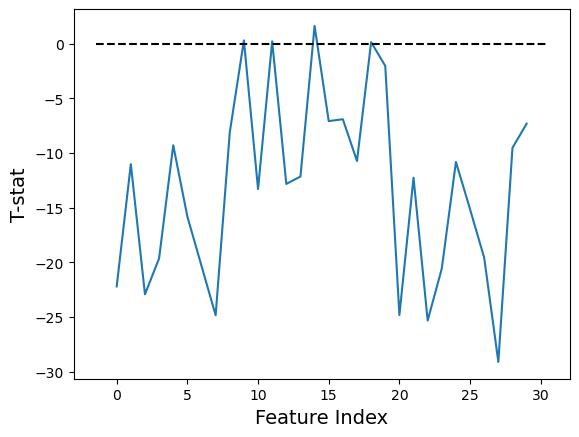

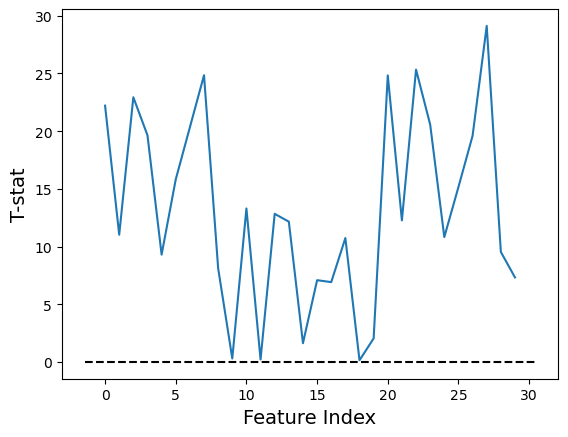

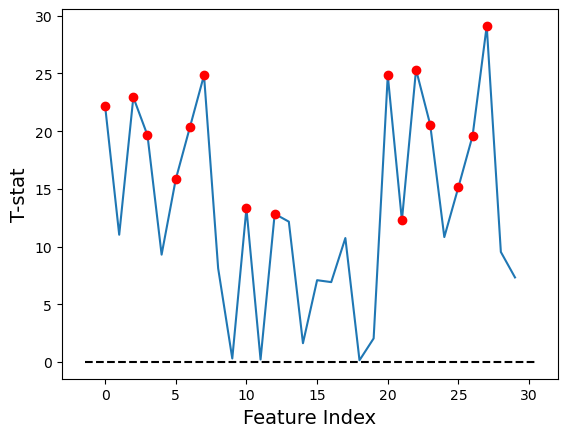

In [12]:
# Basic idea is to find the univariate features that have the best correlation
# with outcome, pick the top M, and use those for classification.

M = 15

# Run 2-sample t-test between remembered and not-remembered items in the feature matrix.
t, p = ttest_ind(X[y==1, :], X[y==0, :], axis=0, equal_var=False)

# Plot results.
plt.figure()
ax = plt.subplot(111)
plt.plot(t);
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='k', linestyles='--')
plt.xlabel('Feature Index', fontsize=14)
plt.ylabel('T-stat', fontsize=14);

# Since we're interested in the most relevant variables for prediction,
# taking the absolute value of the t-stats is helpful.
plt.figure()
ax = plt.subplot(111)
plt.plot(np.abs(t));
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='k', linestyles='--')
plt.xlabel('Feature Index', fontsize=14)
plt.ylabel('T-stat', fontsize=14);

# Rank and select the top 100 most memory-relevant features.
rank_idx = np.argsort(np.abs(t))
picks = rank_idx[-M:]

plt.figure()
ax = plt.subplot(111)
plt.plot(np.abs(t));
plt.plot(picks, np.abs(t)[picks], 'o', color='red')
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='k', linestyles='--')
plt.xlabel('Feature Index', fontsize=14)
plt.ylabel('T-stat', fontsize=14);

## Optimizing Hyperparameters using Nested Cross-Validation

In the previous approaches a fixed penalty parameter (e.g. C = 1) was used for all subjects. Oftentimes we want to tune the hyperparameters of a model to optimize its performance. It is crucial to make it clear that the aim of cross-validation is not to get one or multiple trained models for inference, but to estimate an unbiased generalization performance. We can use a grid search approach in which we search over a grid of 10 values of C logarithmically spaced between $10^{−6}$ and $10^2$ (np.logspace(-6,2,10)). One naive approach is to repeat the earlier analyses for every C value and select the optimal C that maximizes the average AUC across folds. The problem is, if we use the test set multiple times for different trained models, during our selection of the optimal model, the test set actually “leaks” information, and is thus impure or biased. To rigorously select the optimal parameter C and correctly estimate the prediction error of the optimal model, we utilize a nested cross-validation procedure. As the name suggests, we will perform two rounds of cross-validation with the inner CV nested in the outer CV. The outer CV is responsible for obtaining the prediction error for the model and the inner CV is responsible for selecting the optimal hyperparameter for each outer CV fold. We apply the nested cross-validation procedure to our dataset as follows:
* For each subject, divide the dataset into K folds corresponding to K sessions.
* For each fold k = 1, · · · , K (outer loop for evaluation of the model):
    * Let *test* be the kth session (hold-out fold), and *train_val* be all other sessions except the kth fold. *train_val* should have K − 1 sessions. We next perform cross-validation on the train-validation data (inner CV), while leaving the test data alone.
    * For each l = 1, · · · , K − 1 (inner loop for hyperparameter tunning):
        - Let *val_inner* be the held-out fold for the inner CV, and *train_inner* be the other K − 2 sessions except for the lth fold.
        - For each value C in the grid, train a classifier on the *train_inner* data set and obtain prediction for the inner held-out fold, *val_inner*.
        - Repeat the procedure until you sweep through every session of trainval.
    * Select the optimal C from the inner cross-validation that maximizes the inner AUC for the *train_val* data.
    * Retrain the model using the entire *train_val* data with the optimal C.
    * Finally, test the optimal model on the outer held-out fold K.
* Repeat the procedure, holding out each fold in turn as the test fold. As you notice, the procedure above is computationally intensive and requires a lot of data. For instance, R1065J has 10 sessions of data. We perform 10 iterations for the outer CV and for each held-out session in the outer CV, we perform an inner CV procedure on the outer training data, which entails an addition of 9 iterations. On top of it, we need to perform the inner CV for all 10 values of C in the grid. As a result, you will be training 10 × 9 × 10 = 900 classifiers for a single subject using this procedure.